# Classifiers - low vs high complexity - with TFv1
Exploring different classifiers with with the contractive autoencoder. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution() # required for the contractive autoencoder
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [12]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [13]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [16]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [17]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='relu', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='sigmoid', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

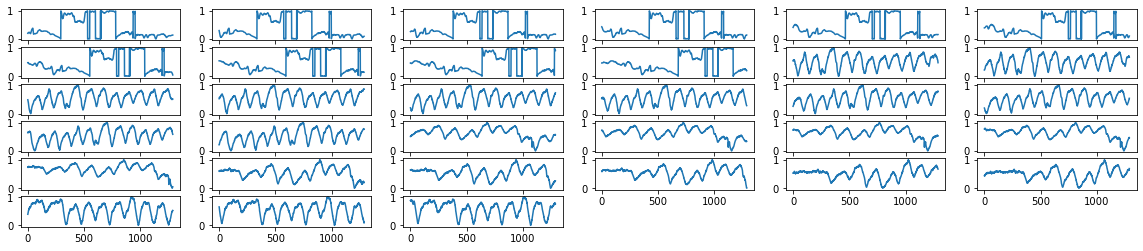

<Figure size 432x288 with 0 Axes>

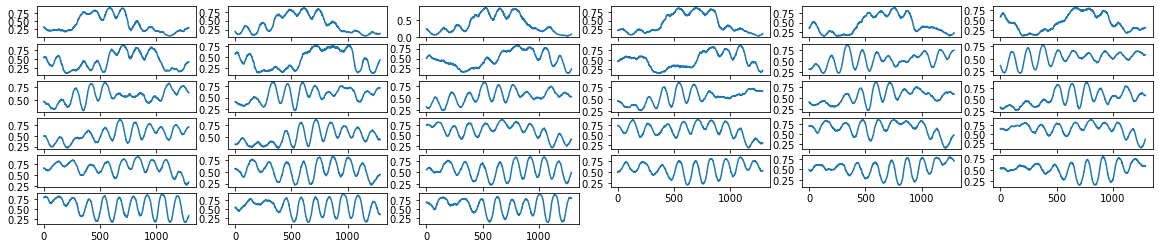

In [19]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

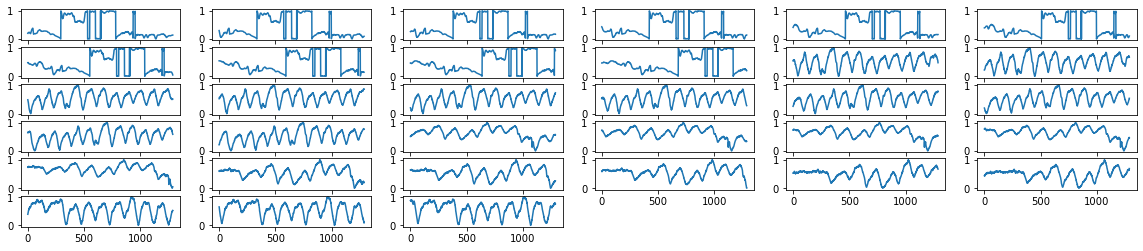

<Figure size 432x288 with 0 Axes>

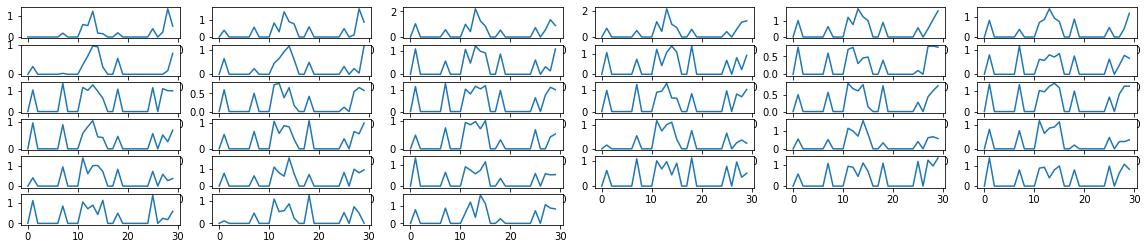

In [20]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [21]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [22]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    return y, phase, contractive_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [23]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):
                set_random_seeds()
                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                # Scale data
                if should_scale_data:
                    # Scale with standard scaler
                    sscaler = StandardScaler()
                    sscaler.fit(train_x)
                    train_x = sscaler.transform(train_x)

                    # Scale valid and test with train's scaler
                    valid_x = sscaler.transform(valid_x)
                    test_x = sscaler.transform(test_x)
                
                # Initialize variables
                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                # Store accuracy
                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [24]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [25]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [26]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_ae_enc
    if (data_name == 'phase'):
        params = params_dense_phase
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [27]:
accs = helper_loop(dense_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.005956
iteration: 2 of 23 ; time elapsed: 0:00:36.870910
iteration: 3 of 23 ; time elapsed: 0:01:12.887933
iteration: 4 of 23 ; time elapsed: 0:01:51.488606
iteration: 5 of 23 ; time elapsed: 0:02:30.785695
iteration: 6 of 23 ; time elapsed: 0:03:09.631685
iteration: 7 of 23 ; time elapsed: 0:03:48.566177
iteration: 8 of 23 ; time elapsed: 0:04:27.703521
iteration: 9 of 23 ; time elapsed: 0:05:11.866479
iteration: 10 of 23 ; time elapsed: 0:05:53.095950
iteration: 11 of 23 ; time elapsed: 0:06:31.806747
iteration: 12 of 23 ; time elapsed: 0:07:18.594539
iteration: 13 of 23 ; time elapsed: 0:08:04.767608
iteration: 14 of 23 ; time elapsed: 0:08:46.711673
iteration: 15 of 23 ; time elapsed: 0:09:27.998749
iteration: 16 of 23 ; time elapsed: 0:10:14.519994
iteration: 17 of 23 ; time elapsed: 0:11:00.429032
iteration: 18 of 23 ; time elapsed: 0:11:46.350721
iteration: 19 of 23 ; time elapsed: 0:12:32.761353
iteration: 20 of 23 ; time elapsed: 0:13

In [28]:
accuracies['simple_dense'] = accs

In [29]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.491667,0.483333,62i9y
1,0.450000,0.350000,2gu87
2,0.408333,0.450000,iz2ps
3,0.558333,0.516667,1mpau
4,0.516667,0.350000,7dwjy
5,0.483333,0.525000,7swyk
6,0.550000,0.575000,94mnx
7,0.583333,0.583333,bd47a
8,0.466667,0.316667,c24ur
9,0.408333,0.425000,ctsax


In [30]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.408333     0.316667
max     0.816667     0.691667
mean    0.548188     0.519565
median  0.533333     0.525000


#### LSTM-based classifier  
based on the original author's code

In [31]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [32]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [33]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_ae_enc
    if (data_name == 'phase'):
        params = params_lstm_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [34]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00.020653
iteration: 2 of 23 ; time elapsed: 0:04:22.205624
iteration: 3 of 23 ; time elapsed: 0:08:55.425922
iteration: 4 of 23 ; time elapsed: 0:13:29.147239
iteration: 5 of 23 ; time elapsed: 0:18:07.249532
iteration: 6 of 23 ; time elapsed: 0:22:48.839500
iteration: 7 of 23 ; time elapsed: 0:27:37.837076
iteration: 8 of 23 ; time elapsed: 0:32:17.828073
iteration: 9 of 23 ; time elapsed: 0:36:59.986978
iteration: 10 of 23 ; time elapsed: 0:41:37.413717
iteration: 11 of 23 ; time elapsed: 0:46:13.774624
iteration: 12 of 23 ; time elapsed: 0:50:48.907186
iteration: 13 of 23 ; time elapsed: 0:55:23.437729
iteration: 14 of 23 ; time elapsed: 1:00:01.534727
iteration: 15 of 23 ; time elapsed: 1:04:56.952798
iteration: 16 of 23 ; time elapsed: 1:10:00.777086
iteration: 17 of 23 ; time elapsed: 1:15:02.774814
iteration: 18 of 23 ; time elapsed: 1:20:09.098873
iteration: 19 of 23 ; time elapsed: 1:25:23.423527
iteration: 20 of 23 ; time elapsed: 1:30

In [35]:
accuracies['LSTM'] = accs

In [36]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.333333,0.450000,62i9y
1,0.491667,0.408333,2gu87
2,0.550000,0.425000,iz2ps
3,0.608333,0.500000,1mpau
4,0.450000,0.575000,7dwjy
5,0.541667,0.408333,7swyk
6,0.708333,0.450000,94mnx
7,0.541667,0.441667,bd47a
8,0.516667,0.300000,c24ur
9,0.491667,0.408333,ctsax


In [37]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.333333     0.300000
max     0.775000     0.675000
mean    0.548188     0.491667
median  0.541667     0.475000


#### kNN

In [38]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [39]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [40]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [41]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_ae_enc
    if (data_name == 'phase'):
        params = params_knn_phase
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [42]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.007582
iteration: 2 of 23 ; time elapsed: 0:00:00.288436
iteration: 3 of 23 ; time elapsed: 0:00:00.509871
iteration: 4 of 23 ; time elapsed: 0:00:00.737266
iteration: 5 of 23 ; time elapsed: 0:00:00.964628
iteration: 6 of 23 ; time elapsed: 0:00:01.227923
iteration: 7 of 23 ; time elapsed: 0:00:01.456344
iteration: 8 of 23 ; time elapsed: 0:00:01.680740
iteration: 9 of 23 ; time elapsed: 0:00:01.901212
iteration: 10 of 23 ; time elapsed: 0:00:02.148582
iteration: 11 of 23 ; time elapsed: 0:00:02.373899
iteration: 12 of 23 ; time elapsed: 0:00:02.598268
iteration: 13 of 23 ; time elapsed: 0:00:02.821670
iteration: 14 of 23 ; time elapsed: 0:00:03.057041
iteration: 15 of 23 ; time elapsed: 0:00:03.324234
iteration: 16 of 23 ; time elapsed: 0:00:03.547670
iteration: 17 of 23 ; time elapsed: 0:00:03.770645
iteration: 18 of 23 ; time elapsed: 0:00:03.998008
iteration: 19 of 23 ; time elapsed: 0:00:04.267286
iteration: 20 of 23 ; time elapsed: 0:00

In [43]:
accuracies['kNN'] = accs

In [44]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.425000,0.525000,62i9y
1,0.666667,0.391667,2gu87
2,0.533333,0.525000,iz2ps
3,0.600000,0.558333,1mpau
4,0.450000,0.533333,7dwjy
5,0.533333,0.583333,7swyk
6,0.641667,0.466667,94mnx
7,0.425000,0.450000,bd47a
8,0.591667,0.383333,c24ur
9,0.425000,0.350000,ctsax


In [45]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.391667     0.350000
max     0.716667     0.658333
mean    0.532971     0.510870
median  0.533333     0.525000


####  SVC

In [46]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [47]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [48]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [49]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_ae_enc
    if (data_name == 'phase'):
        params = params_svc_phase
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [50]:
accs = helper_loop(SVC_train, idents, n=n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00.005986
iteration: 2 of 23 ; time elapsed: 0:00:44.240411
iteration: 3 of 23 ; time elapsed: 0:01:28.945097
iteration: 4 of 23 ; time elapsed: 0:02:13.966773
iteration: 5 of 23 ; time elapsed: 0:02:59.102733
iteration: 6 of 23 ; time elapsed: 0:03:43.878308
iteration: 7 of 23 ; time elapsed: 0:04:29.149510
iteration: 8 of 23 ; time elapsed: 0:05:13.869259
iteration: 9 of 23 ; time elapsed: 0:05:58.375035
iteration: 10 of 23 ; time elapsed: 0:06:42.394199
iteration: 11 of 23 ; time elapsed: 0:07:26.864058
iteration: 12 of 23 ; time elapsed: 0:08:11.446157
iteration: 13 of 23 ; time elapsed: 0:08:55.846559
iteration: 14 of 23 ; time elapsed: 0:09:40.524031
iteration: 15 of 23 ; time elapsed: 0:10:25.433706
iteration: 16 of 23 ; time elapsed: 0:11:09.813763
iteration: 17 of 23 ; time elapsed: 0:11:54.895251
iteration: 18 of 23 ; time elapsed: 0:12:39.982568
iteration: 19 of 23 ; time elapsed: 0:13:24.543638
iteration: 20 of 23 ; time elapsed: 0:14

In [51]:
accuracies['SVC'] = accs

In [52]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.483333,0.466667,62i9y
1,0.400000,0.408333,2gu87
2,0.533333,0.533333,iz2ps
3,0.533333,0.591667,1mpau
4,0.441667,0.500000,7dwjy
5,0.475000,0.533333,7swyk
6,0.533333,0.550000,94mnx
7,0.533333,0.516667,bd47a
8,0.375000,0.308333,c24ur
9,0.466667,0.375000,ctsax


In [53]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.358333     0.308333
max     0.650000     0.641667
mean    0.513043     0.520290
median  0.533333     0.533333


#### Random Forest

In [54]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [55]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [56]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [57]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_ae_enc
    if (data_name == 'phase'):
        params = params_rf_phase
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [58]:
accs = helper_loop(random_forest_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.005984
iteration: 2 of 23 ; time elapsed: 0:00:31.415260
iteration: 3 of 23 ; time elapsed: 0:01:03.285248
iteration: 4 of 23 ; time elapsed: 0:01:34.196027
iteration: 5 of 23 ; time elapsed: 0:02:03.866772
iteration: 6 of 23 ; time elapsed: 0:02:31.549086
iteration: 7 of 23 ; time elapsed: 0:03:02.758235
iteration: 8 of 23 ; time elapsed: 0:03:36.580738
iteration: 9 of 23 ; time elapsed: 0:04:07.873544
iteration: 10 of 23 ; time elapsed: 0:04:38.854989
iteration: 11 of 23 ; time elapsed: 0:05:12.068401
iteration: 12 of 23 ; time elapsed: 0:05:46.701110
iteration: 13 of 23 ; time elapsed: 0:06:23.689414
iteration: 14 of 23 ; time elapsed: 0:07:00.355568
iteration: 15 of 23 ; time elapsed: 0:07:33.036458
iteration: 16 of 23 ; time elapsed: 0:08:05.002098
iteration: 17 of 23 ; time elapsed: 0:08:36.338373
iteration: 18 of 23 ; time elapsed: 0:09:08.737792
iteration: 19 of 23 ; time elapsed: 0:09:41.480044
iteration: 20 of 23 ; time elapsed: 0:10

In [59]:
accuracies['random_forest'] = accs

In [60]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.416667,0.316667,62i9y
1,0.416667,0.425000,2gu87
2,0.425000,0.441667,iz2ps
3,0.616667,0.500000,1mpau
4,0.333333,0.591667,7dwjy
5,0.358333,0.391667,7swyk
6,0.541667,0.475000,94mnx
7,0.533333,0.400000,bd47a
8,0.375000,0.425000,c24ur
9,0.375000,0.333333,ctsax


In [61]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.333333     0.316667
max     0.625000     0.666667
mean    0.472101     0.469928
median  0.458333     0.441667


#### Naive Bayesian

In [62]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [63]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [64]:
accs = helper_loop(naive_bayesian_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.007977
iteration: 2 of 23 ; time elapsed: 0:00:00.281779
iteration: 3 of 23 ; time elapsed: 0:00:00.552058
iteration: 4 of 23 ; time elapsed: 0:00:00.824330
iteration: 5 of 23 ; time elapsed: 0:00:01.099898
iteration: 6 of 23 ; time elapsed: 0:00:01.372174
iteration: 7 of 23 ; time elapsed: 0:00:01.642949
iteration: 8 of 23 ; time elapsed: 0:00:01.902542
iteration: 9 of 23 ; time elapsed: 0:00:02.173817
iteration: 10 of 23 ; time elapsed: 0:00:02.449111
iteration: 11 of 23 ; time elapsed: 0:00:02.718388
iteration: 12 of 23 ; time elapsed: 0:00:02.985367
iteration: 13 of 23 ; time elapsed: 0:00:03.294434
iteration: 14 of 23 ; time elapsed: 0:00:03.561469
iteration: 15 of 23 ; time elapsed: 0:00:03.834784
iteration: 16 of 23 ; time elapsed: 0:00:04.098058
iteration: 17 of 23 ; time elapsed: 0:00:04.362373
iteration: 18 of 23 ; time elapsed: 0:00:04.622649
iteration: 19 of 23 ; time elapsed: 0:00:04.883487
iteration: 20 of 23 ; time elapsed: 0:00

In [65]:
accuracies['naive_bayesian'] = accs

In [66]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.500000,0.466667,62i9y
1,0.475000,0.500000,2gu87
2,0.633333,0.500000,iz2ps
3,0.333333,0.458333,1mpau
4,0.500000,0.483333,7dwjy
5,0.416667,0.416667,7swyk
6,0.500000,0.558333,94mnx
7,0.425000,0.558333,bd47a
8,0.500000,0.541667,c24ur
9,0.500000,0.491667,ctsax


In [67]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.283333     0.416667
max     0.641667     0.600000
mean    0.494565     0.513768
median  0.500000     0.500000


#### XGBoost

In [68]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [69]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [70]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [71]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_ae_enc
    if (data_name == 'phase'):
        params = params_xgb_phase
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [72]:
accs = helper_loop(XGBoost_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.006982
iteration: 2 of 23 ; time elapsed: 0:01:02.252214
iteration: 3 of 23 ; time elapsed: 0:01:58.724361
iteration: 4 of 23 ; time elapsed: 0:03:00.483104
iteration: 5 of 23 ; time elapsed: 0:04:05.656537
iteration: 6 of 23 ; time elapsed: 0:05:04.672171
iteration: 7 of 23 ; time elapsed: 0:06:07.144661
iteration: 8 of 23 ; time elapsed: 0:07:13.534121
iteration: 9 of 23 ; time elapsed: 0:08:17.186131
iteration: 10 of 23 ; time elapsed: 0:09:14.547531
iteration: 11 of 23 ; time elapsed: 0:10:13.542110
iteration: 12 of 23 ; time elapsed: 0:11:16.641740
iteration: 13 of 23 ; time elapsed: 0:12:21.135994
iteration: 14 of 23 ; time elapsed: 0:13:29.308655
iteration: 15 of 23 ; time elapsed: 0:14:39.280261
iteration: 16 of 23 ; time elapsed: 0:15:45.100893
iteration: 17 of 23 ; time elapsed: 0:16:47.122853
iteration: 18 of 23 ; time elapsed: 0:17:49.047839
iteration: 19 of 23 ; time elapsed: 0:18:52.664933
iteration: 20 of 23 ; time elapsed: 0:19

In [73]:
accuracies['XGBoost'] = accs

In [74]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.425000,0.366667,62i9y
1,0.475000,0.458333,2gu87
2,0.391667,0.591667,iz2ps
3,0.600000,0.541667,1mpau
4,0.400000,0.458333,7dwjy
5,0.408333,0.358333,7swyk
6,0.500000,0.483333,94mnx
7,0.491667,0.458333,bd47a
8,0.425000,0.333333,c24ur
9,0.533333,0.458333,ctsax


In [75]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.391667     0.333333
max     0.658333     0.683333
mean    0.486957     0.490942
median  0.483333     0.475000


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [76]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.408333     0.316667
max     0.816667     0.691667
mean    0.548188     0.519565
median  0.533333     0.525000


----------- LSTM: -----------
           phase  contractive
min     0.333333     0.300000
max     0.775000     0.675000
mean    0.548188     0.491667
median  0.541667     0.475000


----------- kNN: -----------
           phase  contractive
min     0.391667     0.350000
max     0.716667     0.658333
mean    0.532971     0.510870
median  0.533333     0.525000


----------- SVC: -----------
           phase  contractive
min     0.358333     0.308333
max     0.650000     0.641667
mean    0.513043     0.520290
median  0.533333     0.533333


----------- random_forest: -----------
           phase  contractive
min     0.333333     0.316667
max     0.625000     0.666667
mean    0.472101     0.469928
median  0.458333     0.441667


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [77]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.491667     0.483333   62i9y
1   0.450000     0.350000   2gu87
2   0.408333     0.450000   iz2ps
3   0.558333     0.516667   1mpau
4   0.516667     0.350000   7dwjy
5   0.483333     0.525000   7swyk
6   0.550000     0.575000   94mnx
7   0.583333     0.583333   bd47a
8   0.466667     0.316667   c24ur
9   0.408333     0.425000   ctsax
10  0.691667     0.541667   dkhty
11  0.508333     0.566667   e4gay
12  0.483333     0.525000   ef5rq
13  0.625000     0.608333   f1gjp
14  0.600000     0.516667   hpbxa
15  0.516667     0.550000   pmyfl
16  0.816667     0.675000   r89k1
17  0.550000     0.691667   tn4vl
18  0.608333     0.516667   td5pr
19  0.583333     0.550000   gyqu9
20  0.691667     0.583333   fzchw
21  0.483333     0.516667   l53hg
22  0.533333     0.533333   3n2f9


LSTM:
       phase  contractive test id
0   0.333333     0.450000   62i9y
1   0.491667     0.408333   2gu87
2   0.550000     0.425000   iz2ps
3   0.608333     0.500000 